# Exercise 3

We generate the same noisy dataset as last time:

In [1]:
import numpy as np

np.random.seed(0)
n_samples = 1000
X = np.random.rand(n_samples)*10
X = np.expand_dims(X, axis=-1)
noise = np.random.randn(n_samples)*4.0
noise = np.expand_dims(noise, axis=-1)
ground_truth = 5 * X + 3
y = ground_truth + noise

In [2]:
print(type(X))
print(type(y))

print(X.shape)
print(y.shape)

print(X.dtype)
print(y.dtype)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1000, 1)
(1000, 1)
float64
float64


## Plotting the data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

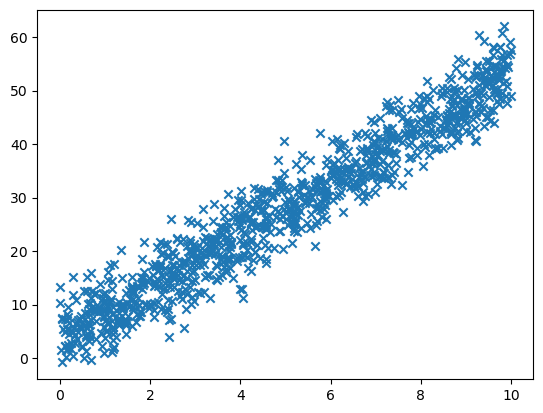

In [4]:
plt.figure()
plt.scatter(X, y, marker="x")
plt.show()

## Setup code

We add an additional column for the bias to the dataset (as per usual):

In [5]:
X_ = np.c_[X, np.ones((X.shape[0]))]

We initialize a weight matrix with random values:

In [6]:
num_samples = X_.shape[0]
num_features = X_.shape[1]

np.random.seed(42)
initial_weights = (np.random.rand(num_features).reshape(-1, 1) * 2 - 1) / np.sqrt(num_features)
weights = initial_weights.copy()

Here is again the code to load the data in chunks / batches:

In [7]:
from math import ceil

BATCH_SIZE = 100
NUM_BATCHES = int(ceil(float(num_samples)/BATCH_SIZE))

def Loader():
    # This generates the batches, one after another
    # For a large dataset, we could load data from disk here
    for i in range(NUM_BATCHES):
        # Get the i'th slice of data
        batch_X = X_[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        batch_y = y[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        yield batch_X, batch_y

## Tasks
Below, you can find an implementation of stochastic gradient descent (the same as in the `exerscise3_sgd.ipynb` notebook).

Your task in this exercise is to adjust the code by implementing other optimizers:
 - SGD with a momentum of 0.3 (add the momentum term to the existing code)
 - SGD with Nesterov momentum of 0.3 (change the code to use nesterov momentum)
 - Adagrad with a learning rate of 0.1 and $\epsilon=10^{-10}$
 - RMSprop with a learning rate of 0.01, $\rho=0.99$ and $\epsilon=10^{-8}$
 - Adadelta with a learning rate of 1, $\rho=0.9$ and $\epsilon=10^{-6}$
 - Adam with a learning rate of 0.01, $\beta_1=0.9$, $\beta_2=0.999$ and $\epsilon=10^{-8}$

For that, save a copy of this file for each individual optimizer. Adapt the code for the optimizer to implement. The last cell of the notebook writes the loss values of each epoch to a file, which can then be loaded and visualized using the `exercise3_optimizers_comparison.ipynb` notebook. Adjust the value of the `optimizer_name` and `optimizer_count` variables below for each optimizer that you implement, so that the loss curves are not overwritten by the different notebooks.

PS: Of course, implement the optimizers manually and do not just use `torch.optim.*` classes, that would defeat the purpose ;-)
You can use `torch.optim.*` classes as a reference of what the correct result would be, or you can just compare your results to the image in `exercise3_optimizers_comparison.ipynb`, which shows the correct results (the same that you would obtain from using the pytorch optimizers).

# SGD 

In [8]:
LR_1 = 0.001  
momentum_1 = 0.3  
  
weights_1 = initial_weights.copy()
velocity_1 = np.zeros_like(weights_1) 

losses_1 = []


for epoch in range(1, 301):
    total_loss_1 = 0
    
    for batch_X, batch_y in Loader():
        num_batch_samples = len(batch_y)
        
        prediction_1 = batch_X @ weights_1
        error_1 = batch_y - prediction_1
        L_1 = np.square(error_1).sum() / num_batch_samples
        
        gradient_1 = -2.0 / num_batch_samples * batch_X.T @ error_1
        velocity_1 = momentum_1 * velocity_1 - LR_1 * gradient_1
        weights_1 += velocity_1
        
        total_loss_1 += L_1.item() * num_batch_samples
    
    
    epoch_loss_1 = total_loss_1 / num_samples
    losses_1.append(epoch_loss_1)
    
    
    if epoch == 1 or epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {epoch_loss_1}")


Epoch 1: Loss 520.5316525340791
Epoch 100: Loss 15.144510424363228
Epoch 200: Loss 14.983534794615274
Epoch 300: Loss 14.944993987624784


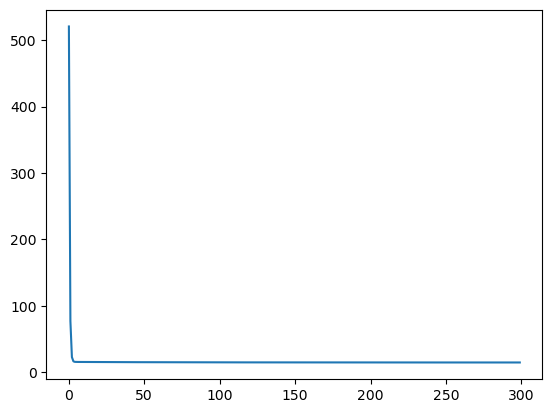

In [9]:
plt.plot(losses_1)
plt.show()

In [10]:
import pickle
with open("1_sgd.pickle", "wb") as f:
    pickle.dump(losses_1, f)

# SGD with Nesterov 

In [11]:
LR_2 = 0.001 
momentum_2 = 0.3  
weights_2 = initial_weights.copy()
velocity_2 = np.zeros_like(weights_2) 

losses_2 = [] 

for epoch in range(1, 301):
    total_loss_2 = 0
    
    for batch_X, batch_y in Loader():
        num_batch_samples = len(batch_y)
        
        lookahead_weights_2 = weights_2 + momentum_2 * velocity_2
        prediction_2 = batch_X @ lookahead_weights_2
        error_2 = batch_y - prediction_2
        L_2 = np.square(error_2).sum() / num_batch_samples
        
        lookahead_gradient_2 = -2.0 / num_batch_samples * batch_X.T @ error_2
        velocity_2 = momentum_2 * velocity_2 - LR_2 * lookahead_gradient_2
        weights_2 += velocity_2
        
        total_loss_2 += L_2.item() * num_batch_samples
    
    
    epoch_loss_2 = total_loss_2 / num_samples
    losses_2.append(epoch_loss_2)
    
    
    if epoch == 1 or epoch % 100 == 0:
        print(f"epoch {epoch} loss: {epoch_loss_2}")


epoch 1 loss: 502.88760430293195
epoch 100 loss: 15.14590198638164
epoch 200 loss: 14.984935353826943
epoch 300 loss: 14.946382126281456


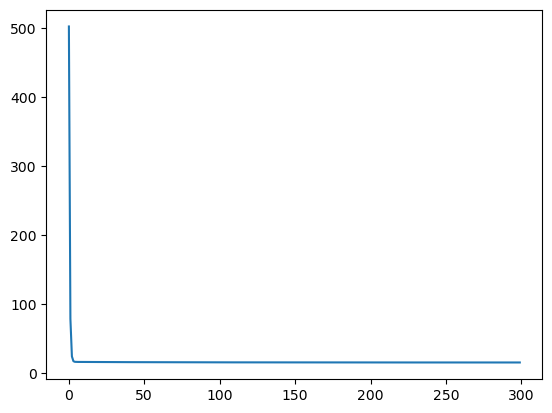

In [12]:
plt.plot(losses_2)
plt.show()

In [13]:
import pickle
with open("1_sgd_nesterov_momentum.pickle", "wb") as f:
    pickle.dump(losses_2, f)

# Adagrad

In [14]:
LR_3 = 0.1 
epsilon_3 = 1e-8  
weights_3 = initial_weights.copy()
gradient_squared_sum_3 = np.zeros_like(weights_3)  

losses_3 = []  

for epoch in range(1, 301):
    total_loss_3 = 0
    
    for batch_X, batch_y in Loader():
        num_batch_samples = len(batch_y)
        
        prediction_3 = batch_X @ weights_3
        error_3 = batch_y - prediction_3
        L_3 = np.square(error_3).sum() / num_batch_samples
        
        gradient_3 = -2.0 / num_batch_samples * batch_X.T @ error_3
        gradient_squared_sum_3 += np.square(gradient_3)
        
        adaptive_lr_3= LR_3 / (np.sqrt(gradient_squared_sum_3) + epsilon_3)
        weights_3 -= adaptive_lr_3 * gradient_3
        
        total_loss_3 += L_3.item() * num_batch_samples
    
   
    epoch_loss_3 = total_loss_3 / num_samples
    losses_3.append(epoch_loss_3)
    
    
    if epoch == 1 or epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {epoch_loss_3}")


Epoch 1: Loss 917.5557919731928
Epoch 100: Loss 31.46933411344216
Epoch 200: Loss 16.493857388013126
Epoch 300: Loss 15.820761197689723


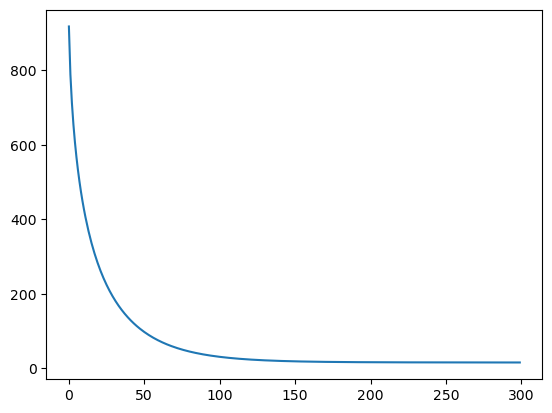

In [15]:
plt.plot(losses_3)
plt.show()

In [16]:
import pickle
with open("1_adagrad.pickle", "wb") as f:
    pickle.dump(losses_3, f)

# RMSprop

In [17]:
LR_4 = 0.01  
alpha_4 = 0.9  
epsilon_4 = 10e-8  
weights_4 = initial_weights.copy()  
gradient_squared_avg_4 = np.zeros_like(weights_4)  

losses_4 = [] 

for epoch in range(1, 301):
    total_loss_4 = 0
    
    for batch_X, batch_y in Loader():
        num_batch_samples = len(batch_y)
        
        prediction_4 = batch_X @ weights_4
        error_4 = batch_y - prediction_4
        L_4 = np.square(error_4).sum() / num_batch_samples
        
        gradient_4 = -2.0 / num_batch_samples * batch_X.T @ error_4
        gradient_squared_avg_4 = alpha_4 * gradient_squared_avg_4 + (1 - alpha_4) * np.square(gradient_4)
        
        weights_4 -= LR_4 * gradient_4 / (np.sqrt(gradient_squared_avg_4) + epsilon_4)
        
        total_loss_4 += L_4.item() * num_batch_samples
    
    
    epoch_loss_4 = total_loss_4 / num_samples
    losses_4.append(epoch_loss_4)
    
    if epoch == 1 or epoch % 100 == 0:
        print(f"epoch {epoch} loss: {epoch_loss_4}")

epoch 1 loss: 991.8203136853655
epoch 100 loss: 14.945392467311432
epoch 200 loss: 14.944288453159746
epoch 300 loss: 14.944288673759585


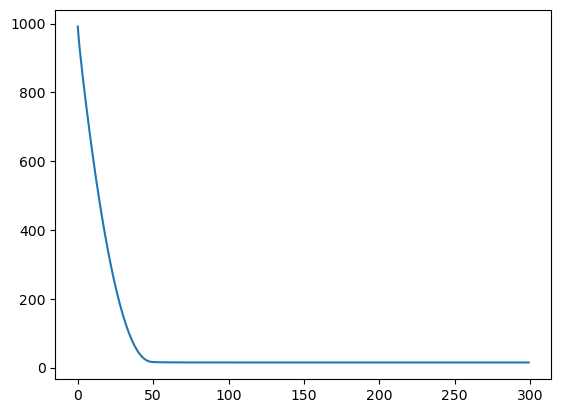

In [18]:
plt.plot(losses_4)
plt.show()

In [19]:
import pickle
with open("1_RMSprop.pickle", "wb") as f:
    pickle.dump(losses_4, f)

# Adadelta 

In [20]:
LR_5 = 0.001  
alpha_5 = 0.9  
epsilon_5 = 10e-6  
weights_5 = initial_weights.copy() 
delta_squared_avg_5 = np.zeros_like(weights_5)  
rms_error_5 = np.zeros_like(weights_5)  

losses_5 = []  

for epoch in range(1, 301):
    total_loss_5 = 0
    
    
    for batch_X, batch_y in Loader():
        num_batch_samples = len(batch_y)
        
        prediction_5 = batch_X @ weights_5
        error_5 = batch_y - prediction_5
        L_5 = np.square(error_5).sum() / num_batch_samples
        
        gradient_5 = -2.0 / num_batch_samples * batch_X.T @ error_5
        
        
        if np.linalg.norm(gradient_5) > 5.0:
            gradient_5 *= 5.0 / np.linalg.norm(gradient_5)
        
        delta_squared_avg_5 = alpha_5 * delta_squared_avg_5 + (1 - alpha_5) * np.square(gradient_5)
        
        rms_error_5 = np.sqrt(delta_squared_avg_5 + epsilon_5)
        delta_5 = - (rms_error_5 / np.sqrt(delta_squared_avg_5 + epsilon_5)) * gradient_5
        
        weights_5 += LR_5 * delta_5
        
        total_loss_5 += L_5.item() * num_batch_samples
    
    epoch_loss_5 = total_loss_5 / num_samples
    losses_5.append(epoch_loss_5)
    
    
    if epoch == 1 or epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {epoch_loss_5}")


Epoch 1: Loss 1022.3012175192774
Epoch 100: Loss 24.50037366933583
Epoch 200: Loss 15.274330051873058
Epoch 300: Loss 15.06252152786763


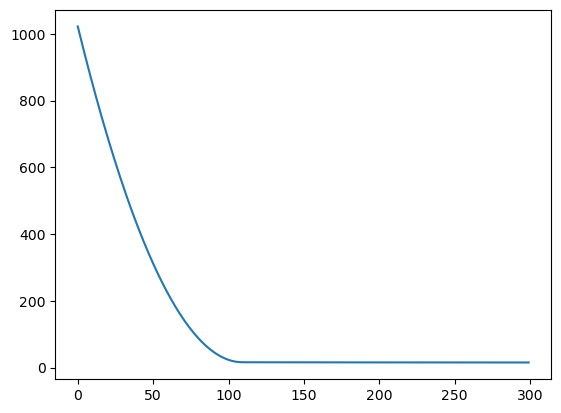

In [21]:
plt.plot(losses_5)
plt.show()

In [22]:
import pickle
with open("1_Adadelta.pickle", "wb") as f:
    pickle.dump(losses_5, f)

# Adam 

In [23]:
LR_6 = 0.01  
beta1 = 0.9  
beta2 = 0.999  
epsilon_6 = 1e-8 
weights_6 = initial_weights.copy()  
m = np.zeros_like(weights_6)  
u = np.zeros_like(weights_6) 

losses_6 = []  

for epoch in range(1, 301):
    total_loss_6 = 0
    
    for batch_X, batch_y in Loader():
        num_batch_samples = len(batch_y)
        
        prediction_6 = batch_X @ weights_6
        error_6 = batch_y - prediction_6
        L_6 = np.square(error_6).sum() / num_batch_samples
        
        gradient_6 = -2.0 / num_batch_samples * batch_X.T @ error_6

        m = beta1 * m + (1 - beta1) * gradient_6
        u = beta2 * u + (1 - beta2) * np.square(gradient_6)
        
        m_hat = m / (1 - beta1 ** epoch)
        u_hat = u / (1 - beta2 ** epoch)
        
        weights_6 -= LR_6 * m_hat / (np.sqrt(u_hat) + epsilon_6)
        
        total_loss_6 += L_6.item() * num_batch_samples
    
 
    epoch_loss_6 = total_loss_6 / num_samples
    losses_6.append(epoch_loss_6)
    
   
    if epoch == 1 or epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {epoch_loss_6}")


Epoch 1: Loss 1001.5081951905559
Epoch 100: Loss 103.2380790863432
Epoch 200: Loss 16.875109146171656
Epoch 300: Loss 15.640255793960586


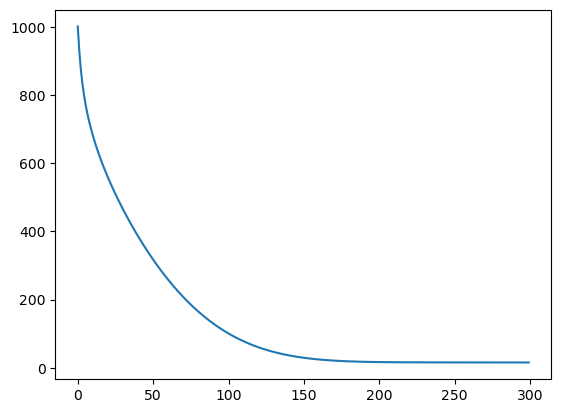

In [24]:
plt.plot(losses_6)
plt.show()

In [25]:
import pickle
with open("1_Adam.pickle", "wb") as f:
    pickle.dump(losses_6, f)

<_io.BufferedReader name='1_Adadelta.pickle'>
<_io.BufferedReader name='1_Adam.pickle'>
<_io.BufferedReader name='1_RMSprop.pickle'>
<_io.BufferedReader name='1_adagrad.pickle'>
<_io.BufferedReader name='1_sgd.pickle'>
<_io.BufferedReader name='1_sgd_nesterov_momentum.pickle'>


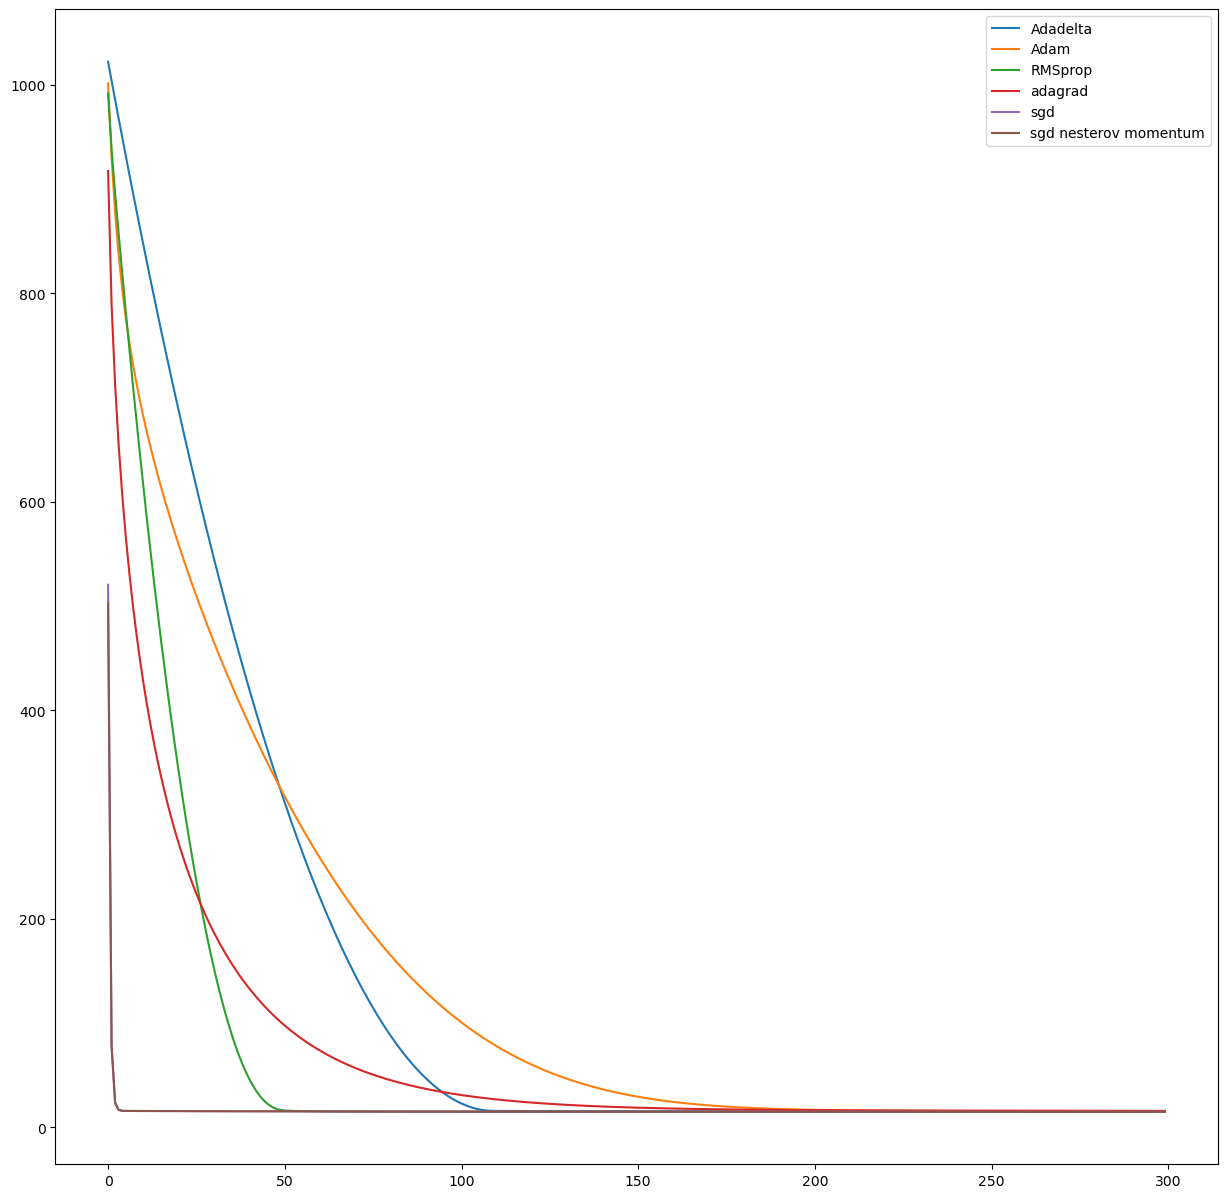

In [26]:
import glob
import pickle

plt.figure(figsize=(15, 15))
for filename in sorted(glob.glob('*.pickle')):
    with open(filename, 'rb') as f:
        print(f)
        losses = pickle.load(f)

    plt.plot(losses, label=" ".join(filename.split('.')[0].split('_')[1:]))

plt.legend()
plt.show()